In [1]:
!pip install sec-edgar-downloader
!pip install beautifulsoup4 -q
!pip install yfinance -q

import yfinance as yf
from sec_edgar_downloader import Downloader
from google.colab import files
import os, re
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [2]:
# get the data from sec
dl = Downloader('/content/AMD_project', '8@e.com') # to access sec data, must provide email

for form_type in ['10-K', '10-Q']:
    dl.get(form_type, '0000002488', after='2015-01-01', before='2024-12-31')


In [3]:
!zip -r AMD_filings.zip /content/sec-edgar-filings
files.download('AMD_filings.zip')

  adding: content/sec-edgar-filings/ (stored 0%)
  adding: content/sec-edgar-filings/0000002488/ (stored 0%)
  adding: content/sec-edgar-filings/0000002488/10-K/ (stored 0%)
  adding: content/sec-edgar-filings/0000002488/10-K/0000002488-16-000111/ (stored 0%)
  adding: content/sec-edgar-filings/0000002488/10-K/0000002488-16-000111/full-submission.txt (deflated 89%)
  adding: content/sec-edgar-filings/0000002488/10-K/0001193125-15-054362/ (stored 0%)
  adding: content/sec-edgar-filings/0000002488/10-K/0001193125-15-054362/full-submission.txt (deflated 88%)
  adding: content/sec-edgar-filings/0000002488/10-K/0000002488-23-000047/ (stored 0%)
  adding: content/sec-edgar-filings/0000002488/10-K/0000002488-23-000047/full-submission.txt (deflated 86%)
  adding: content/sec-edgar-filings/0000002488/10-K/0000002488-20-000008/ (stored 0%)
  adding: content/sec-edgar-filings/0000002488/10-K/0000002488-20-000008/full-submission.txt (deflated 88%)
  adding: content/sec-edgar-filings/0000002488/10-

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
base_path = '/content/sec-edgar-filings/0000002488'

def infer_year_and_seq(folder_name: str):
    """
    Label the files with the year and quarter using seq number.
    """
    m = re.match(r'.*-(\d{2})-(\d+)$', folder_name)
    if not m:
        return None, None
    yy = int(m.group(1))
    year = 2000 + yy
    seq = int(m.group(2))
    return year, seq

records = []
for form_type in ['10-Q', '10-K']:
    folder = os.path.join(base_path, form_type)
    for sub in sorted(os.listdir(folder)):
        path = os.path.join(folder, sub)
        if not os.path.isdir(path):
            continue
        year, seq = infer_year_and_seq(sub)
        if year is None:
            continue

        if 2015 <= year <= 2024:
            records.append({
                'form': form_type,
                'folder': sub,
                'year': year,
                'seq': seq,
                'path': path
            })

df = pd.DataFrame(records)

# check the result
print('Number of files:', len(df))
print('\n Number of K & Qs in each year：')
print(df.groupby(['year', 'form']).size().unstack(fill_value=0))

# label each file
labels = []
final_rows = []
for y in range(2015, 2025):
    q_rows = df[(df['year'] == y) & (df['form'] == '10-Q')].sort_values('seq')
    k_rows = df[(df['year'] == y) & (df['form'] == '10-K')].sort_values('seq')

    # only 3 Qs a year
    q_rows = q_rows.head(3).copy()

    for i, (_, r) in enumerate(q_rows.iterrows(), start=1):
        r = r.copy()
        r['label'] = f'{y}Q{i}'
        final_rows.append(r)

    # only 1 k
    if len(k_rows) > 0:
        r = k_rows.iloc[0].copy()
        r['label'] = f'{y}K'
        final_rows.append(r)

final_df = pd.DataFrame(final_rows)

def label_sort_key(lbl):
    # 2015Q1 -> (2015, 1) ; 2015K -> (2015, 4)
    year = int(lbl[:4])
    suffix = lbl[4:]
    if suffix == "K":
        order = 4
    else:
        order = int(suffix[1])  # Q1/Q2/Q3
    return (year, order)

final_df = final_df.sort_values(by="label", key=lambda s: s.map(label_sort_key)).reset_index(drop=True)

display(final_df[['form', 'year', 'seq', 'label', 'folder', 'path']])

final_df.to_csv('AMD_filing_list_labeled.csv', index=False)
print('check df len', len(final_df))


Number of files: 40

 Number of K & Qs in each year：
form  10-K  10-Q
year            
2015     1     3
2016     1     3
2017     1     3
2018     1     3
2019     1     3
2020     1     3
2021     1     3
2022     1     3
2023     1     3
2024     1     3


,form,year,seq,label,folder,path
0,10-Q,2015,67,2015Q1,0000002488-15-000067,/content/sec-edgar-filings/0000002488/10-Q/000...
1,10-Q,2015,5620,2015Q2,0001628280-15-005620,/content/sec-edgar-filings/0000002488/10-Q/000...
2,10-Q,2015,156842,2015Q3,0001193125-15-156842,/content/sec-edgar-filings/0000002488/10-Q/000...
3,10-K,2015,54362,2015K,0001193125-15-054362,/content/sec-edgar-filings/0000002488/10-K/000...
4,10-Q,2016,124,2016Q1,0000002488-16-000124,/content/sec-edgar-filings/0000002488/10-Q/000...
5,10-Q,2016,213,2016Q2,0000002488-16-000213,/content/sec-edgar-filings/0000002488/10-Q/000...
6,10-Q,2016,263,2016Q3,0000002488-16-000263,/content/sec-edgar-filings/0000002488/10-Q/000...
7,10-K,2016,111,2016K,0000002488-16-000111,/content/sec-edgar-filings/0000002488/10-K/000...
8,10-Q,2017,107,2017Q1,0000002488-17-000107,/content/sec-edgar-filings/0000002488/10-Q/000...
9,10-Q,2017,156,2017Q2,0000002488-17-000156,/content/sec-edgar-filings/0000002488/10-Q/000...


check df len 40


In [25]:
def extract_full_text(file_path):
    """
    Extract the full main 10-K or 10-Q filing text from a SEC full-submission file.
    Works for newer SEC HTML structures as well.
    """
    try:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            content = f.read()
    except Exception:
        return ""

    # Find all <DOCUMENT> blocks
    docs = re.findall(r"<DOCUMENT>(.*?)</DOCUMENT>", content, flags=re.DOTALL | re.IGNORECASE)
    if not docs:
        return ""

    for d in docs:
        # Extract TYPE tag
        type_match = re.search(r"<TYPE>\s*([^\n<]+)", d, flags=re.IGNORECASE)
        doc_type = type_match.group(1).strip().upper() if type_match else ""
        if doc_type in ["10-K", "10-Q"]:
            # Extract everything between <TEXT> and </TEXT> (covers both HTML and plain text)
            text_match = re.search(r"<TEXT>(.*?)</TEXT>", d, flags=re.DOTALL | re.IGNORECASE)
            if not text_match:
                continue
            filing_text = text_match.group(1)

            # If it looks like HTML, strip tags with BeautifulSoup
            if "<HTML" in filing_text.upper():
                soup = BeautifulSoup(filing_text, "html.parser")
                text = soup.get_text(" ", strip=True)
            else:
                text = filing_text

            # Clean: uppercase + remove non-letters
            text = text.upper()
            text = re.sub(r"[^A-Z\s]", " ", text)
            text = " ".join(text.split())
            return text

    # Nothing matched (no 10-K or 10-Q found)
    return ""


df = pd.read_csv("AMD_filing_list_labeled.csv")

texts = []
for _, row in df.iterrows():
    file_path = os.path.join(row["path"], "full-submission.txt")
    if os.path.exists(file_path):
        text = extract_full_text(file_path)
        texts.append(text)
    else:
        texts.append("")

df["clean_text"] = texts
df.to_csv("AMD_cleaned_texts.csv", index=False)
print("Extracted", len(df), "files successfully.")

Extracted 40 files successfully.


In [40]:
amd = pd.read_csv('AMD_cleaned_texts.csv')
amd['tokens'] = amd['clean_text'].str.split()
amd['tokens'].head()

,tokens
0,"[Q, UNITED, STATES, SECURITIES, AND, EXCHANGE,..."
1,"[AMD, Q, UNITED, STATES, SECURITIES, AND, EXCH..."
2,"[FORM, Q, TABLE, OF, CONTENTS, UNITED, STATES,..."
3,"[K, TABLE, OF, CONTENTS, UNITED, STATES, SECUR..."
4,"[Q, UNITED, STATES, SECURITIES, AND, EXCHANGE,..."


In [27]:
# get the dictionary
lmd = pd.read_csv('Loughran-McDonald_MasterDictionary_1993-2024.csv')
lmd.head()

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Complexity,Syllables,Source
0,AARDVARK,1,755,2.955070e-08,1.945421e-08,4.078069e-06,140,0,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.174200e-10,8.060019e-12,8.919011e-09,1,0,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.522600e-10,1.089343e-10,5.105359e-08,7,0,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.135060e-09,6.197922e-10,1.539279e-07,28,0,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,9620,3.765268e-07,3.825261e-07,3.421836e-05,1295,0,0,0,0,0,0,0,0,3,12of12inf


In [28]:
# get the positive and negative words
positive = set(lmd[lmd['Positive'] >0 ]['Word'])
negative = set(lmd[lmd['Negative'] > 0]['Word'])

In [29]:
def count_sentiment(words):
    pos = sum(1 for w in words if w in positive)
    neg = sum(1 for w in words if w in negative)
    return pos, neg

In [31]:
amd[["pos", "neg"]] = amd["tokens"].apply(lambda x: pd.Series(count_sentiment(x)))
amd["sentiment"] = (amd["pos"] - amd["neg"]) / (amd["pos"] + amd["neg"])
amd.head()

,form,folder,year,seq,path,label,clean_text,tokens,pos,neg,sentiment
0,10-Q,0000002488-15-000067,2015,67,/content/sec-edgar-filings/0000002488/10-Q/000...,2015Q1,Q UNITED STATES SECURITIES AND EXCHANGE COMMIS...,"[Q, UNITED, STATES, SECURITIES, AND, EXCHANGE,...",214,1025,-0.654560
1,10-Q,0001628280-15-005620,2015,5620,/content/sec-edgar-filings/0000002488/10-Q/000...,2015Q2,AMD Q UNITED STATES SECURITIES AND EXCHANGE CO...,"[AMD, Q, UNITED, STATES, SECURITIES, AND, EXCH...",225,976,-0.625312
2,10-Q,0001193125-15-156842,2015,156842,/content/sec-edgar-filings/0000002488/10-Q/000...,2015Q3,FORM Q TABLE OF CONTENTS UNITED STATES SECURIT...,"[FORM, Q, TABLE, OF, CONTENTS, UNITED, STATES,...",208,884,-0.619048
3,10-K,0001193125-15-054362,2015,54362,/content/sec-edgar-filings/0000002488/10-K/000...,2015K,K TABLE OF CONTENTS UNITED STATES SECURITIES A...,"[K, TABLE, OF, CONTENTS, UNITED, STATES, SECUR...",377,1243,-0.534568
4,10-Q,0000002488-16-000124,2016,124,/content/sec-edgar-filings/0000002488/10-Q/000...,2016Q1,Q UNITED STATES SECURITIES AND EXCHANGE COMMIS...,"[Q, UNITED, STATES, SECURITIES, AND, EXCHANGE,...",209,902,-0.623762


In [32]:
sent = amd.copy()

# map each label to a representative date
sent["Date"] = sent["label"].str.replace("Q1", "-03-31") \
                            .str.replace("Q2", "-06-30") \
                            .str.replace("Q3", "-09-30") \
                            .str.replace("K", "-12-31")
sent["Date"] = pd.to_datetime(sent["Date"])
sent.fillna(0, inplace=True)
sent

,form,folder,year,seq,path,label,clean_text,tokens,pos,neg,sentiment,Date
0,10-Q,0000002488-15-000067,2015,67,/content/sec-edgar-filings/0000002488/10-Q/000...,2015Q1,Q UNITED STATES SECURITIES AND EXCHANGE COMMIS...,"[Q, UNITED, STATES, SECURITIES, AND, EXCHANGE,...",214,1025,-0.654560,2015-03-31
1,10-Q,0001628280-15-005620,2015,5620,/content/sec-edgar-filings/0000002488/10-Q/000...,2015Q2,AMD Q UNITED STATES SECURITIES AND EXCHANGE CO...,"[AMD, Q, UNITED, STATES, SECURITIES, AND, EXCH...",225,976,-0.625312,2015-06-30
2,10-Q,0001193125-15-156842,2015,156842,/content/sec-edgar-filings/0000002488/10-Q/000...,2015Q3,FORM Q TABLE OF CONTENTS UNITED STATES SECURIT...,"[FORM, Q, TABLE, OF, CONTENTS, UNITED, STATES,...",208,884,-0.619048,2015-09-30
3,10-K,0001193125-15-054362,2015,54362,/content/sec-edgar-filings/0000002488/10-K/000...,2015K,K TABLE OF CONTENTS UNITED STATES SECURITIES A...,"[K, TABLE, OF, CONTENTS, UNITED, STATES, SECUR...",377,1243,-0.534568,2015-12-31
4,10-Q,0000002488-16-000124,2016,124,/content/sec-edgar-filings/0000002488/10-Q/000...,2016Q1,Q UNITED STATES SECURITIES AND EXCHANGE COMMIS...,"[Q, UNITED, STATES, SECURITIES, AND, EXCHANGE,...",209,902,-0.623762,2016-03-31
5,10-Q,0000002488-16-000213,2016,213,/content/sec-edgar-filings/0000002488/10-Q/000...,2016Q2,DOCUMENT UNITED STATES SECURITIES AND EXCHANGE...,"[DOCUMENT, UNITED, STATES, SECURITIES, AND, EX...",236,924,-0.593103,2016-06-30
6,10-Q,0000002488-16-000263,2016,263,/content/sec-edgar-filings/0000002488/10-Q/000...,2016Q3,DOCUMENT UNITED STATES SECURITIES AND EXCHANGE...,"[DOCUMENT, UNITED, STATES, SECURITIES, AND, EX...",245,973,-0.597701,2016-09-30
7,10-K,0000002488-16-000111,2016,111,/content/sec-edgar-filings/0000002488/10-K/000...,2016K,K UNITED STATES SECURITIES AND EXCHANGE COMMIS...,"[K, UNITED, STATES, SECURITIES, AND, EXCHANGE,...",366,1405,-0.586674,2016-12-31
8,10-Q,0000002488-17-000107,2017,107,/content/sec-edgar-filings/0000002488/10-Q/000...,2017Q1,DOCUMENT UNITED STATES SECURITIES AND EXCHANGE...,"[DOCUMENT, UNITED, STATES, SECURITIES, AND, EX...",214,954,-0.633562,2017-03-31
9,10-Q,0000002488-17-000156,2017,156,/content/sec-edgar-filings/0000002488/10-Q/000...,2017Q2,DOCUMENT UNITED STATES SECURITIES AND EXCHANGE...,"[DOCUMENT, UNITED, STATES, SECURITIES, AND, EX...",238,1029,-0.624309,2017-06-30


In [33]:
sent.dtypes

,0
form,object
folder,object
year,int64
seq,int64
path,object
label,object
clean_text,object
tokens,object
pos,int64
neg,int64


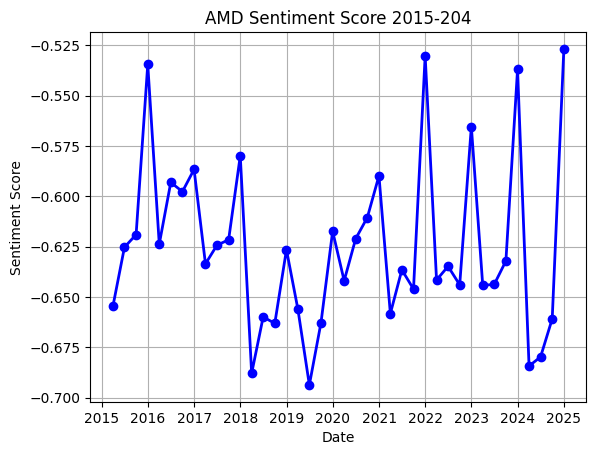

In [34]:
# sentiment score plot

x = sent['Date']
y = sent['sentiment']

plt.plot(x, y, color='blue', linewidth=2, marker='o')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('AMD Sentiment Score 2015-204')

plt.grid(True)
plt.show()


In [41]:
price = yf.download('AMD', start='2015-01-01', end='2025-01-01')
price = price[['Close']]             # keep only close price
price.reset_index(inplace=True)
price.columns = price.columns.droplevel(0)
price.columns = ['Date', 'Close']
price['Date'] = pd.to_datetime(price['Date'])

/tmp/ipython-input-1963118930.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price = yf.download('AMD', start='2015-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


In [42]:
# merge sentiment score and stock price
sent_price = pd.merge_asof(sent, price, on='Date', direction='nearest')
sent_price

,form,folder,year,seq,path,label,clean_text,tokens,pos,neg,sentiment,Date,Close
0,10-Q,0000002488-15-000067,2015,67,/content/sec-edgar-filings/0000002488/10-Q/000...,2015Q1,Q UNITED STATES SECURITIES AND EXCHANGE COMMIS...,"[Q, UNITED, STATES, SECURITIES, AND, EXCHANGE,...",214,1025,-0.654560,2015-03-31,2.680000
1,10-Q,0001628280-15-005620,2015,5620,/content/sec-edgar-filings/0000002488/10-Q/000...,2015Q2,AMD Q UNITED STATES SECURITIES AND EXCHANGE CO...,"[AMD, Q, UNITED, STATES, SECURITIES, AND, EXCH...",225,976,-0.625312,2015-06-30,2.400000
2,10-Q,0001193125-15-156842,2015,156842,/content/sec-edgar-filings/0000002488/10-Q/000...,2015Q3,FORM Q TABLE OF CONTENTS UNITED STATES SECURIT...,"[FORM, Q, TABLE, OF, CONTENTS, UNITED, STATES,...",208,884,-0.619048,2015-09-30,1.720000
3,10-K,0001193125-15-054362,2015,54362,/content/sec-edgar-filings/0000002488/10-K/000...,2015K,K TABLE OF CONTENTS UNITED STATES SECURITIES A...,"[K, TABLE, OF, CONTENTS, UNITED, STATES, SECUR...",377,1243,-0.534568,2015-12-31,2.870000
4,10-Q,0000002488-16-000124,2016,124,/content/sec-edgar-filings/0000002488/10-Q/000...,2016Q1,Q UNITED STATES SECURITIES AND EXCHANGE COMMIS...,"[Q, UNITED, STATES, SECURITIES, AND, EXCHANGE,...",209,902,-0.623762,2016-03-31,2.850000
5,10-Q,0000002488-16-000213,2016,213,/content/sec-edgar-filings/0000002488/10-Q/000...,2016Q2,DOCUMENT UNITED STATES SECURITIES AND EXCHANGE...,"[DOCUMENT, UNITED, STATES, SECURITIES, AND, EX...",236,924,-0.593103,2016-06-30,5.140000
6,10-Q,0000002488-16-000263,2016,263,/content/sec-edgar-filings/0000002488/10-Q/000...,2016Q3,DOCUMENT UNITED STATES SECURITIES AND EXCHANGE...,"[DOCUMENT, UNITED, STATES, SECURITIES, AND, EX...",245,973,-0.597701,2016-09-30,6.910000
7,10-K,0000002488-16-000111,2016,111,/content/sec-edgar-filings/0000002488/10-K/000...,2016K,K UNITED STATES SECURITIES AND EXCHANGE COMMIS...,"[K, UNITED, STATES, SECURITIES, AND, EXCHANGE,...",366,1405,-0.586674,2016-12-31,11.340000
8,10-Q,0000002488-17-000107,2017,107,/content/sec-edgar-filings/0000002488/10-Q/000...,2017Q1,DOCUMENT UNITED STATES SECURITIES AND EXCHANGE...,"[DOCUMENT, UNITED, STATES, SECURITIES, AND, EX...",214,954,-0.633562,2017-03-31,14.550000
9,10-Q,0000002488-17-000156,2017,156,/content/sec-edgar-filings/0000002488/10-Q/000...,2017Q2,DOCUMENT UNITED STATES SECURITIES AND EXCHANGE...,"[DOCUMENT, UNITED, STATES, SECURITIES, AND, EX...",238,1029,-0.624309,2017-06-30,12.480000


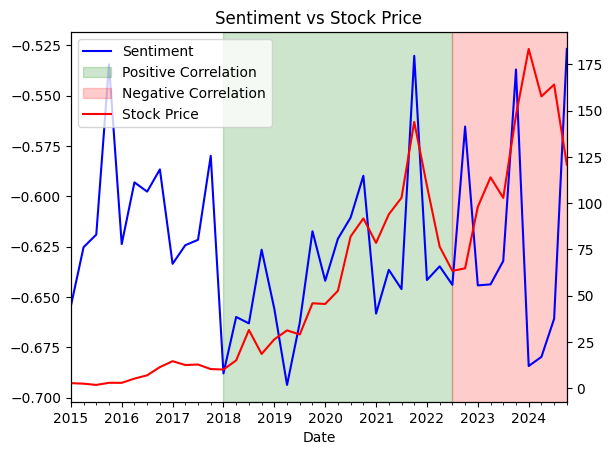

In [49]:
ax1 = sent_price.plot(x='Date', y='sentiment', color='blue', label='Sentiment', legend=False)
ax2 = ax1.twinx()
sent_price.plot(x='Date', y='Close', color='red', label='Stock Price', ax=ax2, legend=False)

# green: 2018 - 2022Q2 sentiment score and stock price has same direction
ax1.axvspan(pd.Timestamp('2018-01-01'), pd.Timestamp('2022-07-31'),
             color='green', alpha=0.2, label='Positive Correlation')

# red: 202Q2 - 2024K sentiment score goes opposite from stock price
ax1.axvspan(pd.Timestamp('2022-07-31'), sent_price['Date'].max(),
             color='red', alpha=0.2, label='Negative Correlation')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Sentiment vs Stock Price')
plt.show()

# Brief Discussion

Overall, AMD’s sentiment scores remain negative (below -0.5) throughout 2015–2024. While both sentiment and stock price exhibit some co-movement during certain periods, their relationship appears weak before early 2018.

From early 2018 to around Q3 2022, sentiment and stock price tend to move in the same direction, suggesting a positive correlation. However, from Q3 2022 to the end of 2024, their movements are opposite, indicating a negative relationship between sentiment and stock performance during this later period.